# Defino directorio donde se encuentran los datos de entrenamiento

In [1]:
from google.colab import drive
from pathlib import Path
import sys

base = Path('/content/gdrive/My Drive/ML_Trabajo_Final/')
sys.path.append(str(base))

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Transfiero mis datos (imágenes) a Colab y descomprimo

In [2]:
%%time
zip_path = base/'Data_Huracan.zip'
!cp "{zip_path}" .
!unzip -q Data_Huracan.zip
!rm Data_Huracan.zip

CPU times: user 12.9 ms, sys: 15.1 ms, total: 28.1 ms
Wall time: 3.05 s


# Pasamos nuestros datos a un Pandas DataFrame para explorarlos

In [3]:
import pandas as pd

datos_path = "/content/Data_Huracan"

image_df = pd.DataFrame({'path': list(Path(datos_path).glob('**/*.jp*g'))})

image_df['damage'] = image_df['path'].map(lambda x: x.parent.stem)
image_df['data_split'] = image_df['path'].map(lambda x: x.parent.parent.stem)
image_df['location'] = image_df['path'].map(lambda x: x.stem)
image_df['lon'] = image_df['location'].map(lambda x: float(x.split('_')[0]))
image_df['lat'] = image_df['location'].map(lambda x: float(x.split('_')[-1]))
image_df['path'] = image_df['path'].map(lambda x: str(x)) # convert the path back to a string

image_df.head()

,path,damage,data_split,location,lon,lat
0,/content/Data_Huracan/test/damage/-95.6444_29....,damage,test,-95.6444_29.771534000000003,-95.644400,29.771534
1,/content/Data_Huracan/test/damage/-95.123733_3...,damage,test,-95.123733_30.033535999999998,-95.123733,30.033536
2,/content/Data_Huracan/test/damage/-93.6141_30....,damage,test,-93.6141_30.754263,-93.614100,30.754263
3,/content/Data_Huracan/test/damage/-95.559089_2...,damage,test,-95.559089_29.759673,-95.559089,29.759673
4,/content/Data_Huracan/test/damage/-96.98546_28...,damage,test,-96.98546_28.785055,-96.985460,28.785055


In [4]:
len(image_df)

23000

# Vemos la distribución espacial de nuestras imágenes en base a sus coordenadas

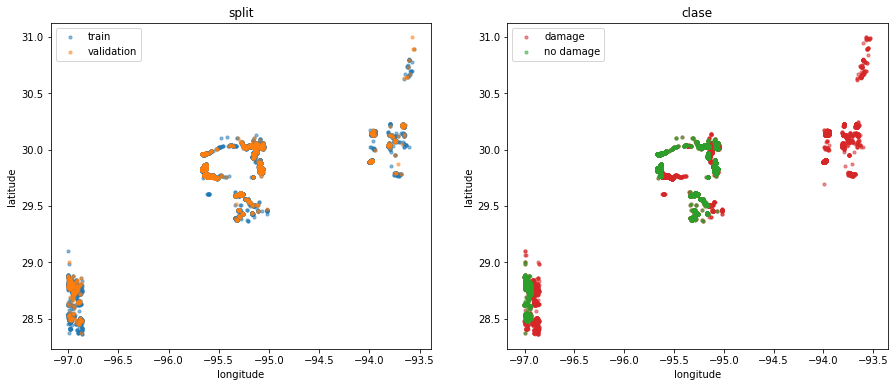

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

s = 10 #tamaño del punto
alpha = 0.5

# get the train-validation-test splits
image_df_train = image_df[image_df['data_split']=='train'].copy()
image_df_val = image_df[image_df['data_split']=='validation_another'].copy()
image_df_test = image_df[image_df['data_split']=='test'].copy()

# sort to ensure reproducible behaviour
image_df_train.sort_values('lat', inplace=True) #Ordeno los datos por latitud
image_df_val.sort_values('lat', inplace=True)
image_df_test.sort_values('lat', inplace=True)
image_df_train.reset_index(drop=True,inplace=True) #Lo vuelvo a indexar
image_df_val.reset_index(drop=True,inplace=True)
image_df_test.reset_index(drop=True,inplace=True)

ax[0].scatter(image_df_train['lon'], image_df_train['lat'], color='C0', s=s, alpha=alpha, label='train')
ax[0].scatter(image_df_val['lon'], image_df_val['lat'], color='C1', s=s, alpha=alpha, label='validation')

ax[0].set_title('split')
ax[0].legend()
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')

image_df_dmg = image_df[image_df['damage']=='damage'].copy()
image_df_nodmg = image_df[image_df['damage']=='no_damage'].copy()

image_df_dmg.reset_index(drop=True,inplace=True)
image_df_nodmg.reset_index(drop=True,inplace=True)

ax[1].scatter(image_df_dmg['lon'], image_df_dmg['lat'], color='C3', s=s, alpha=alpha, label='damage')
ax[1].scatter(image_df_nodmg['lon'], image_df_nodmg['lat'], color='C2', s=s, alpha=alpha, label='no damage')

ax[1].set_title('clase')
ax[1].legend()
ax[1].set_xlabel('longitude')
ax[1].set_ylabel('latitude')

plt.show(fig)

# Probamos que se lean bien las imágenes

In [6]:
import cv2
img1 = cv2.imread('/content/Data_Huracan/train/no_damage/-95.06546800000001_29.832415.jpeg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
print(img1)

[[[ 98 106  67]
  [ 98 106  67]
  [ 98 106  67]
  ...
  [ 97 105  66]
  [ 99 107  68]
  [100 108  69]]

 [[ 98 106  67]
  [ 98 106  67]
  [ 98 106  67]
  ...
  [ 97 105  66]
  [ 99 107  68]
  [100 108  69]]

 [[ 98 106  67]
  [ 98 106  67]
  [ 98 106  67]
  ...
  [ 97 105  66]
  [ 99 107  68]
  [100 108  69]]

 ...

 [[167 145 108]
  [149 127  90]
  [144 120  84]
  ...
  [ 23  43  16]
  [ 19  42  13]
  [ 17  40  11]]

 [[170 142 105]
  [154 126  89]
  [150 120  84]
  ...
  [ 19  39  12]
  [ 24  44  16]
  [ 20  40  12]]

 [[170 140 102]
  [156 126  88]
  [153 121  83]
  ...
  [ 31  51  24]
  [ 40  60  32]
  [ 35  55  27]]]


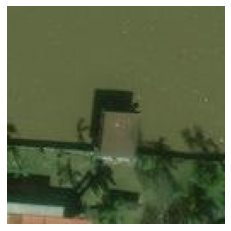

In [7]:
import matplotlib.pyplot as plt

plt.imshow(img1, cmap = 'gray')
plt.axis('off')
plt.show()

# Defino las carpetas en donde se encuentran las imágenes de entrenamiento por clase

In [9]:
DIRECTORIO_DATASET = "/content/Data_Huracan/train"

In [10]:
CATEGORIAS = ['no_damage', 'damage']

# Creo lista vacía para almacenar datos cargados

In [11]:
datos_entrenamiento = []

# Defino una función que carga las imágenes como Array con OpenCV y las almacena en la lista definida en la celda anterior

In [12]:
import os

def crearDatasetEntrenamiento():
    for categoria in CATEGORIAS:
        path = os.path.join(DIRECTORIO_DATASET, categoria)
        clase = CATEGORIAS.index(categoria)
        for imagen in os.listdir(path):
            imagen_array = cv2.imread(os.path.join(path, imagen))
            imgen_array = cv2.cvtColor(imagen_array, cv2.COLOR_BGR2RGB)
            datos_entrenamiento.append([imagen_array, clase])

# Ejecuto la función y genero mi "dataset" de entrenamiento

In [13]:
crearDatasetEntrenamiento()

# Analizo mi "dataset"

In [14]:
print(len(datos_entrenamiento)) #Chequeo longitud

10000


In [15]:
print(datos_entrenamiento[4999]) #Veo una posición del dataset. Las primeras 4999 imágenes son no_damage(0) y el resto son damage(1)

[array([[[ 75,  94,  97],
        [ 76,  95,  98],
        [ 82,  98, 104],
        ...,
        [ 66,  98,  87],
        [ 77, 109,  98],
        [ 74, 106,  95]],

       [[ 84, 103, 106],
        [101, 120, 123],
        [108, 125, 128],
        ...,
        [ 66,  98,  87],
        [ 71, 103,  92],
        [ 77, 109,  98]],

       [[121, 141, 142],
        [129, 149, 150],
        [123, 141, 142],
        ...,
        [ 70, 100,  89],
        [ 68,  98,  87],
        [ 83, 113, 102]],

       ...,

       [[ 71,  91,  86],
        [ 64,  84,  79],
        [ 63,  83,  78],
        ...,
        [ 78,  96,  95],
        [ 73,  91,  90],
        [ 63,  81,  80]],

       [[ 71,  91,  86],
        [ 66,  86,  81],
        [ 68,  88,  83],
        ...,
        [104, 125, 122],
        [ 97, 118, 115],
        [ 76,  97,  94]],

       [[ 73,  93,  88],
        [ 69,  89,  84],
        [ 72,  92,  87],
        ...,
        [140, 161, 158],
        [135, 156, 153],
        [107, 128, 125]

# Mezclo valores para no condicionar a la red por el posicionamiento de datos cargados

In [16]:
import random

random.shuffle(datos_entrenamiento)
random.shuffle(datos_entrenamiento)
random.shuffle(datos_entrenamiento)

In [17]:
print(datos_entrenamiento[4999]) #Pruebo ejemplos y veo que los datos se han mezclado correctamente

[array([[[54, 75, 73],
        [51, 72, 70],
        [47, 68, 66],
        ...,
        [53, 74, 82],
        [55, 76, 84],
        [56, 77, 85]],

       [[45, 66, 64],
        [47, 68, 66],
        [51, 72, 70],
        ...,
        [54, 75, 83],
        [55, 76, 84],
        [56, 77, 85]],

       [[45, 65, 66],
        [47, 67, 68],
        [52, 72, 73],
        ...,
        [53, 75, 81],
        [54, 75, 83],
        [54, 75, 83]],

       ...,

       [[32, 65, 51],
        [34, 67, 52],
        [38, 71, 57],
        ...,
        [52, 75, 77],
        [54, 77, 79],
        [57, 80, 82]],

       [[26, 62, 46],
        [29, 65, 48],
        [35, 71, 55],
        ...,
        [51, 74, 76],
        [54, 77, 79],
        [56, 79, 81]],

       [[33, 69, 52],
        [35, 71, 54],
        [39, 75, 58],
        ...,
        [55, 78, 80],
        [52, 75, 77],
        [50, 73, 75]]], dtype=uint8), 1]


# Creo 2 listas vacías, una que almacene las imágenes y otra las etiquetas

In [18]:
X_trainL = []
y_trainL = []

# Separo imágenes y etiquetas

In [19]:
for imagen, etiqueta in datos_entrenamiento:
    X_trainL.append(imagen)
    y_trainL.append(etiqueta)

In [20]:
type(X_trainL) #veo que es una lista

list

In [21]:
len(X_trainL) #de longitud 10000

10000

In [22]:
print(X_trainL[0]) #veo un dato de la lista de entrenamiento (un array de imagen)

[[[ 72  93  78]
  [ 76  97  82]
  [ 74  97  82]
  ...
  [ 99 125 125]
  [ 97 123 123]
  [ 96 122 122]]

 [[ 69  90  75]
  [ 72  93  78]
  [ 71  94  79]
  ...
  [112 138 138]
  [107 133 133]
  [103 129 129]]

 [[ 66  87  72]
  [ 69  90  75]
  [ 68  91  77]
  ...
  [126 152 152]
  [120 146 146]
  [114 140 140]]

 ...

 [[ 55  74  71]
  [ 50  69  66]
  [ 46  63  59]
  ...
  [ 61  87  74]
  [ 62  88  75]
  [ 61  87  74]]

 [[ 62  81  78]
  [ 57  76  73]
  [ 52  71  68]
  ...
  [ 62  90  77]
  [ 63  91  78]
  [ 61  89  76]]

 [[ 60  79  76]
  [ 57  76  73]
  [ 56  75  72]
  ...
  [ 66  94  81]
  [ 67  95  82]
  [ 65  93  80]]]


In [23]:
type(X_trainL[0])

numpy.ndarray

In [24]:
X_trainL[0] #dtype uint8

array([[[ 72,  93,  78],
        [ 76,  97,  82],
        [ 74,  97,  82],
        ...,
        [ 99, 125, 125],
        [ 97, 123, 123],
        [ 96, 122, 122]],

       [[ 69,  90,  75],
        [ 72,  93,  78],
        [ 71,  94,  79],
        ...,
        [112, 138, 138],
        [107, 133, 133],
        [103, 129, 129]],

       [[ 66,  87,  72],
        [ 69,  90,  75],
        [ 68,  91,  77],
        ...,
        [126, 152, 152],
        [120, 146, 146],
        [114, 140, 140]],

       ...,

       [[ 55,  74,  71],
        [ 50,  69,  66],
        [ 46,  63,  59],
        ...,
        [ 61,  87,  74],
        [ 62,  88,  75],
        [ 61,  87,  74]],

       [[ 62,  81,  78],
        [ 57,  76,  73],
        [ 52,  71,  68],
        ...,
        [ 62,  90,  77],
        [ 63,  91,  78],
        [ 61,  89,  76]],

       [[ 60,  79,  76],
        [ 57,  76,  73],
        [ 56,  75,  72],
        ...,
        [ 66,  94,  81],
        [ 67,  95,  82],
        [ 65,  93,  80]]

In [25]:
y_trainL[0] #veo un dato de y_train (clase)

0

In [26]:
y_trainL

[0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


# Transformo las listas en Arreglos de Numpy (Tensores) para que sea el formato válido de Keras

In [27]:
import numpy as np
from tensorflow import keras

X_train = np.array(X_trainL)
y_train = np.array(y_trainL)

# Analizo mis arraglos

In [28]:
X_train

array([[[[ 72,  93,  78],
         [ 76,  97,  82],
         [ 74,  97,  82],
         ...,
         [ 99, 125, 125],
         [ 97, 123, 123],
         [ 96, 122, 122]],

        [[ 69,  90,  75],
         [ 72,  93,  78],
         [ 71,  94,  79],
         ...,
         [112, 138, 138],
         [107, 133, 133],
         [103, 129, 129]],

        [[ 66,  87,  72],
         [ 69,  90,  75],
         [ 68,  91,  77],
         ...,
         [126, 152, 152],
         [120, 146, 146],
         [114, 140, 140]],

        ...,

        [[ 55,  74,  71],
         [ 50,  69,  66],
         [ 46,  63,  59],
         ...,
         [ 61,  87,  74],
         [ 62,  88,  75],
         [ 61,  87,  74]],

        [[ 62,  81,  78],
         [ 57,  76,  73],
         [ 52,  71,  68],
         ...,
         [ 62,  90,  77],
         [ 63,  91,  78],
         [ 61,  89,  76]],

        [[ 60,  79,  76],
         [ 57,  76,  73],
         [ 56,  75,  72],
         ...,
         [ 66,  94,  81],
        

In [29]:
y_train

array([0, 1, 1, ..., 1, 1, 1])

In [30]:
print(type(X_train)) #tipo de X_train. Es array
print(X_train.shape) #Veo dimensiones. 10000 imágenes de 128x128 RGB.
print()
print(type(y_train)) #tipo de y_train. Es array
print(y_train.shape) #Dimensiones
print(y_train.size) #Cantidad de valores

<class 'numpy.ndarray'>
(10000, 128, 128, 3)

<class 'numpy.ndarray'>
(10000,)
10000


In [31]:
print(X_train[0].shape) #veo dimensiones de un dato de X_train
print(type(X_train[0]))

(128, 128, 3)
<class 'numpy.ndarray'>


In [46]:
print(X_train.dtype)
print(y_train.dtype)
#arr = arr.astype('float64') 

uint8
float32


In [33]:
print(y_train[0]) #veo de qué clase es el primer dato
print(X_train[0])

0
[[[ 72  93  78]
  [ 76  97  82]
  [ 74  97  82]
  ...
  [ 99 125 125]
  [ 97 123 123]
  [ 96 122 122]]

 [[ 69  90  75]
  [ 72  93  78]
  [ 71  94  79]
  ...
  [112 138 138]
  [107 133 133]
  [103 129 129]]

 [[ 66  87  72]
  [ 69  90  75]
  [ 68  91  77]
  ...
  [126 152 152]
  [120 146 146]
  [114 140 140]]

 ...

 [[ 55  74  71]
  [ 50  69  66]
  [ 46  63  59]
  ...
  [ 61  87  74]
  [ 62  88  75]
  [ 61  87  74]]

 [[ 62  81  78]
  [ 57  76  73]
  [ 52  71  68]
  ...
  [ 62  90  77]
  [ 63  91  78]
  [ 61  89  76]]

 [[ 60  79  76]
  [ 57  76  73]
  [ 56  75  72]
  ...
  [ 66  94  81]
  [ 67  95  82]
  [ 65  93  80]]]


In [34]:
y_train #imprimo datos de clases, se ve que están mezclados

array([0, 1, 1, ..., 1, 1, 1])

In [35]:
unicas, cantidad = np.unique(y_train, return_counts = True)

print(f'El dataset posee las siguientes clases: {unicas}, y a cada clase le corresponde la siguiente cantidad: {cantidad}')

El dataset posee las siguientes clases: [0 1], y a cada clase le corresponde la siguiente cantidad: [5000 5000]


### Mostramos 10 imágenes al azar con su respectiva etiqueta

La posición de la imagen a mostrar es la 7550
La etiqueta de la imagen es: 1


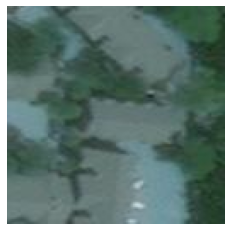

La posición de la imagen a mostrar es la 9171
La etiqueta de la imagen es: 0


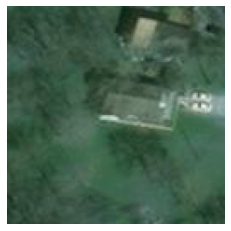

La posición de la imagen a mostrar es la 1363
La etiqueta de la imagen es: 0


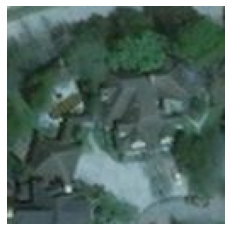

La posición de la imagen a mostrar es la 7670
La etiqueta de la imagen es: 0


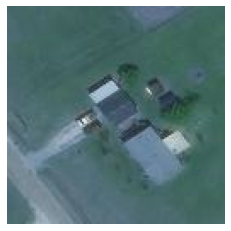

La posición de la imagen a mostrar es la 4477
La etiqueta de la imagen es: 0


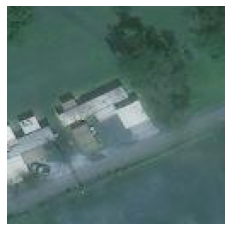

La posición de la imagen a mostrar es la 4280
La etiqueta de la imagen es: 0


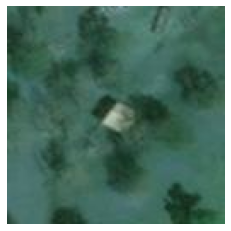

La posición de la imagen a mostrar es la 833
La etiqueta de la imagen es: 1


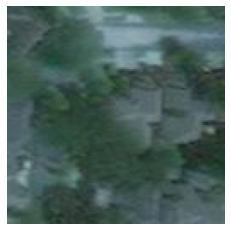

La posición de la imagen a mostrar es la 3155
La etiqueta de la imagen es: 1


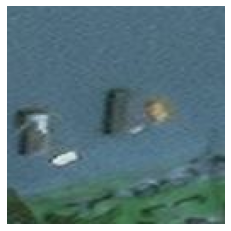

La posición de la imagen a mostrar es la 504
La etiqueta de la imagen es: 0


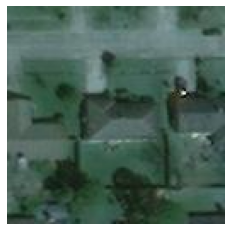

La posición de la imagen a mostrar es la 4436
La etiqueta de la imagen es: 0


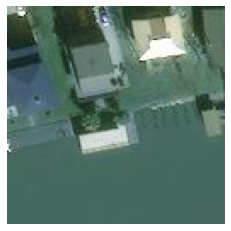

In [36]:
for i in range(10):
    ima = np.random.randint(low = 0, high = 10000)
    print(f'La posición de la imagen a mostrar es la {ima}')
    print(f'La etiqueta de la imagen es: {y_train[ima]}')
    plt.imshow(X_train[ima, :, :], cmap = 'gray')
    plt.axis('off')
    plt.show()

# Paso a one hot

In [37]:
y_train = keras.utils.to_categorical(y_train)

In [38]:
print(type(y_train)) #array
print(y_train.shape) #nuevas dimensiones

<class 'numpy.ndarray'>
(10000, 2)


In [39]:
y_train[0] #analizo un ejemplo

array([1., 0.], dtype=float32)

In [40]:
y_train #imprimo clases one hot

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# Hacemos lo mismo con los datos de validation y test

In [41]:
import os
import cv2
import random
import numpy as np
from tensorflow import keras

DIRECTORIO_DATASET = "/content/Data_Huracan/validation_another"
CATEGORIAS = ['no_damage', 'damage']
datos_validacion = []

def crearDatasetValidacion():
    for categoria in CATEGORIAS:
        path = os.path.join(DIRECTORIO_DATASET, categoria)
        clase = CATEGORIAS.index(categoria)
        for imagen in os.listdir(path):
            imagen_array = cv2.imread(os.path.join(path, imagen))
            imgen_array = cv2.cvtColor(imagen_array, cv2.COLOR_BGR2RGB)
            datos_validacion.append([imagen_array, clase])
            
crearDatasetValidacion()

random.shuffle(datos_validacion)
random.shuffle(datos_validacion)
random.shuffle(datos_validacion)

X_val = []
y_val = []

for imagen, etiqueta in datos_validacion:
    X_val.append(imagen)
    y_val.append(etiqueta)
    
X_val = np.array(X_val)
y_val = np.array(y_val)
y_val = keras.utils.to_categorical(y_val)

In [42]:
import os
import cv2
import random
import numpy as np
from tensorflow import keras

DIRECTORIO_DATASET = "/content/Data_Huracan/test"
CATEGORIAS = ['no_damage', 'damage']
datos_test = []

def crearDatasetTest():
    for categoria in CATEGORIAS:
        path = os.path.join(DIRECTORIO_DATASET, categoria)
        clase = CATEGORIAS.index(categoria)
        for imagen in os.listdir(path):
            imagen_array = cv2.imread(os.path.join(path, imagen))
            imgen_array = cv2.cvtColor(imagen_array, cv2.COLOR_BGR2RGB)
            datos_test.append([imagen_array, clase])
            
crearDatasetTest()

random.shuffle(datos_test)
random.shuffle(datos_test)
random.shuffle(datos_test)

X_test = []
y_test = []

for imagen, etiqueta in datos_test:
    X_test.append(imagen)
    y_test.append(etiqueta)
    
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test = keras.utils.to_categorical(y_test)

# Analizamos algunos datos

In [43]:
print(X_train.shape)
print(y_train.shape)

(10000, 128, 128, 3)
(10000, 2)


In [44]:
print(y_train[0])

[1. 0.]


In [45]:
print(X_val.shape)
print(y_val.shape)

(2000, 128, 128, 3)
(2000, 2)


# Aumentación de datos

In [48]:
def flip(imagen):
    imagen = Image.fromarray(imagen)
    imagen_flipped = imagen.transpose(method=Image.FLIP_LEFT_RIGHT)
    return np.array(imagen_flipped)

In [49]:
def rotacion(imagen, angulo):
    imagen = Image.fromarray(imagen)
    imagen_rotada = imagen.rotate(angle = angulo, expand = False)
    return np.array(imagen_rotada)

In [50]:
def aumentacion(imagenes, etiquetas):
    lista_imagenes = []
    lista_etiquetas = []
    
    for i in range(imagenes.shape[0]):
        
        imagen, etiqueta = imagenes[i], etiquetas[i]

        lista_imagenes.append(imagen)
        lista_etiquetas.append(etiqueta)

        lista_imagenes.append(rotacion(imagen, 10))
        lista_etiquetas.append(etiqueta)    

        lista_imagenes.append(rotacion(imagen, -10))
        lista_etiquetas.append(etiqueta)

        lista_imagenes.append(flip(imagen))
        lista_etiquetas.append(etiqueta)
        
    list_aux = list(zip(lista_imagenes, lista_etiquetas))

    random.shuffle(list_aux)
    random.shuffle(list_aux)
    random.shuffle(list_aux)

    lista_imagenes, lista_etiquetas = zip(*list_aux)
    
    return np.asarray(lista_imagenes), np.asarray(lista_etiquetas)

In [52]:
from PIL import Image

X_train, y_train = aumentacion(X_train, y_train)

print(X_train.shape, y_train.shape)

(40000, 128, 128, 3) (40000, 2)


In [53]:
X_val, y_val = aumentacion(X_val, y_val)

print(X_val.shape, y_val.shape)

(8000, 128, 128, 3) (8000, 2)


# Entrenamos con una red convolucional

RED NEURONAL CONVOLUCIONAL

Epoch 1/10
157/157 [==============================] - 30s 140ms/step - loss: 1.3109 - accuracy: 0.8095 - val_loss: 0.3262 - val_accuracy: 0.8597
Epoch 2/10
157/157 [==============================] - 22s 139ms/step - loss: 0.1259 - accuracy: 0.9517 - val_loss: 0.2000 - val_accuracy: 0.9326
Epoch 3/10
157/157 [==============================] - 22s 139ms/step - loss: 0.1004 - accuracy: 0.9623 - val_loss: 0.2820 - val_accuracy: 0.9013
Epoch 4/10
157/157 [==============================] - 22s 141ms/step - loss: 0.0769 - accuracy: 0.9709 - val_loss: 0.4785 - val_accuracy: 0.8780
Epoch 5/10
157/157 [==============================] - 22s 142ms/step - loss: 0.0567 - accuracy: 0.9800 - val_loss: 0.2075 - val_accuracy: 0.9286
Epoch 6/10
157/157 [==============================] - 23s 144ms/step - loss: 0.0561 - accuracy: 0.9793 - val_loss: 0.1692 - val_accuracy: 0.9455
Epoch 7/10
157/157 [==============================] - 23s 145ms/step - loss: 0.0489 - accuracy: 0.9817

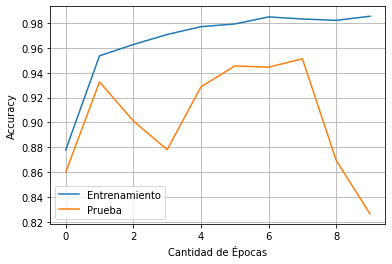

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256   

In [54]:
#RED NEURONAL CONVOLUCIONAL

import tensorflow
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import cv2
import random
import numpy as np

print('RED NEURONAL CONVOLUCIONAL')
print('')

#Estructura de la red neuronal
Imagen_de_entrada = layers.Input(shape = (128, 128, 3)) #Capa de entrada
X = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = None)(Imagen_de_entrada) #Capa de convolución
X = layers.BatchNormalization()(X) #Capa de normalización y relu
X = layers.Activation("relu")(X)
X = layers.MaxPooling2D(pool_size = (2, 2))(X) #Capa de pooling
X = layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = None)(X) #Segunda capa de convolución
X = layers.BatchNormalization()(X) #Capa de normalización y relu
X = layers.Activation("relu")(X)
X = layers.MaxPooling2D(pool_size = (2, 2))(X) #Capa de pooling

#Red fully connected
Flatten = layers.Flatten()(X) #Capa de flatten
X = layers.Dense(32, activation = "relu")(Flatten) #Capa oculta
X = layers.Dense(64, activation = "relu")(X) #Capa oculta
Salida = layers.Dense(units = 2, activation = 'softmax')(X) #Capa de salida

#Instancia de clase
Red_Neuronal = keras.Model(inputs = Imagen_de_entrada, outputs = Salida)

#Compilación de modelo
Red_Neuronal.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

#Entrenamos la red con nuestros datos
Historia = Red_Neuronal.fit(x = X_train, y = y_train, epochs = 10, batch_size = 256, validation_data = (X_val, y_val))

#Grafico las métricas de mi red
plt.plot(Historia.history['accuracy'], label = 'Entrenamiento')
plt.plot(Historia.history['val_accuracy'], label = 'Prueba')
plt.grid()
plt.xlabel('Cantidad de Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Muestro arquitectura y parámetros de mi red
Red_Neuronal.summary()

In [86]:
Red_Neuronal.save('Modelo_32.h5') #Guardamos el modelo

# Red_Neuronal = keras.models.load_model('Modelo_32.h5') #Con esto podemos cargar el modelo

- Con 64 o 256 neuronas en la primera capa oculta obteníamos underfitting y todos los valores constantes. Accuracy, loss.
- Con 128 neuronas en la primera capa oculta tuvimos overfitting.
- Mejoró en validation con relu en la capa fully connected y bajando a 32 la cantidad de neuronas en la primera capa oculta.

# Probamos con batch 64 y binary_crossentropy

RED NEURONAL CONVOLUCIONAL

Epoch 1/15
157/157 [==============================] - 23s 144ms/step - loss: 0.7052 - accuracy: 0.8522 - val_loss: 1.3467 - val_accuracy: 0.6201
Epoch 2/15
157/157 [==============================] - 23s 146ms/step - loss: 0.1507 - accuracy: 0.9414 - val_loss: 1.1119 - val_accuracy: 0.6876
Epoch 3/15
157/157 [==============================] - 23s 144ms/step - loss: 0.0796 - accuracy: 0.9711 - val_loss: 0.2839 - val_accuracy: 0.8890
Epoch 4/15
157/157 [==============================] - 23s 143ms/step - loss: 0.0703 - accuracy: 0.9753 - val_loss: 0.2030 - val_accuracy: 0.9250
Epoch 5/15
157/157 [==============================] - 23s 144ms/step - loss: 0.0543 - accuracy: 0.9807 - val_loss: 0.1140 - val_accuracy: 0.9574
Epoch 6/15
157/157 [==============================] - 23s 144ms/step - loss: 0.0510 - accuracy: 0.9811 - val_loss: 0.9085 - val_accuracy: 0.6919
Epoch 7/15
157/157 [==============================] - 23s 144ms/step - loss: 0.0394 - accuracy: 0.9861

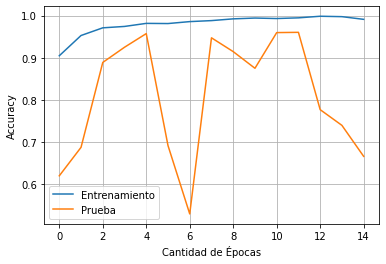

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
activation_4 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 61, 64)        256 

In [56]:
#RED NEURONAL CONVOLUCIONAL

import tensorflow
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import cv2
import random
import numpy as np

print('RED NEURONAL CONVOLUCIONAL')
print('')

#Estructura de la red neuronal
Imagen_de_entrada = layers.Input(shape = (128, 128, 3)) #Capa de entrada
X = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = None)(Imagen_de_entrada) #Capa de convolución
X = layers.BatchNormalization()(X) #Capa de normalización y relu
X = layers.Activation("relu")(X)
X = layers.MaxPooling2D(pool_size = (2, 2))(X) #Capa de pooling
X = layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = None)(X) #Segunda capa de convolución
X = layers.BatchNormalization()(X) #Capa de normalización y relu
X = layers.Activation("relu")(X)
X = layers.MaxPooling2D(pool_size = (2, 2))(X) #Capa de pooling

#Red fully connected
Flatten = layers.Flatten()(X) #Capa de flatten
X = layers.Dense(32, activation = "relu")(Flatten) #Capa oculta
X = layers.Dense(64, activation = "relu")(X) #Capa oculta
Salida = layers.Dense(units = 2, activation = 'softmax')(X) #Capa de salida

#Instancia de clase
Red_Neuronal = keras.Model(inputs = Imagen_de_entrada, outputs = Salida)

#Compilación de modelo
Red_Neuronal.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

#Entrenamos la red con nuestros datos
Historia = Red_Neuronal.fit(x = X_train, y = y_train, epochs = 15, batch_size = 256, validation_data = (X_val, y_val))

#Grafico las métricas de mi red
plt.plot(Historia.history['accuracy'], label = 'Entrenamiento')
plt.plot(Historia.history['val_accuracy'], label = 'Prueba')
plt.grid()
plt.xlabel('Cantidad de Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Muestro arquitectura y parámetros de mi red
Red_Neuronal.summary()

In [ ]:
Red_Neuronal.save('Modelo_binary.h5') #Guardamos el modelo

# Revisamos las salidas de las capas para analizar qué está haciendo nuestra red

In [57]:
capas_salida = [capa.output for capa in Red_Neuronal.layers]

In [58]:
Modelo_Salidas = keras.Model(inputs = Red_Neuronal.input, outputs = capas_salida)

In [59]:
Xte = X_train[0:3, :, :, :]

In [60]:
Salidas = Modelo_Salidas.predict(Xte)

In [61]:
primera_capa = Salidas[0]
segunda_capa = Salidas[1]
tercera_capa = Salidas[2]

In [62]:
primera_capa[1, :, :, 0].shape

(128, 128)

In [63]:
segunda_capa[1, :, :, 0].shape

(126, 126)

In [64]:
tercera_capa[1, :, :, 0].shape

(126, 126)

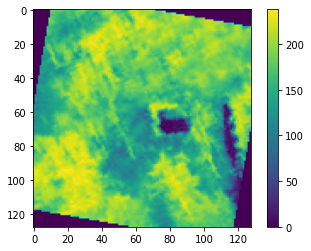

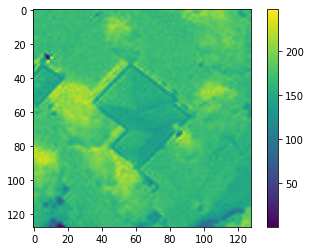

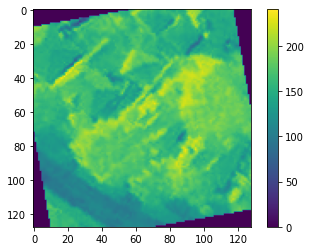

In [65]:
for i in np.arange(0, 3):
    plt.imshow((primera_capa[i, :, :, 1] * 255).astype(np.uint8))
    plt.colorbar()
    plt.show()

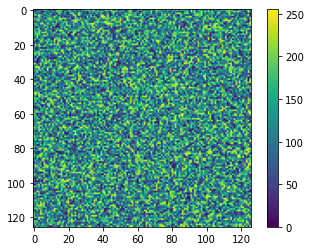

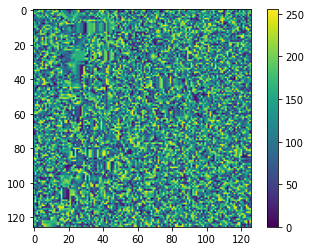

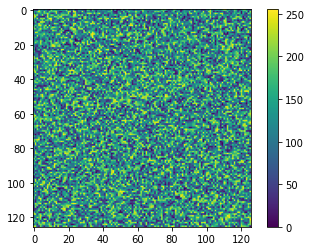

In [97]:
for i in np.arange(0, 3):
    plt.imshow((segunda_capa[i, :, :, 1] * 255).astype(np.uint8))
    plt.colorbar()
    plt.show()

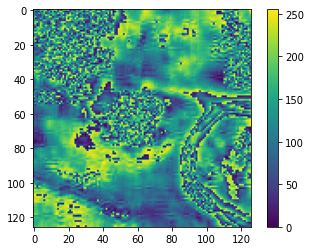

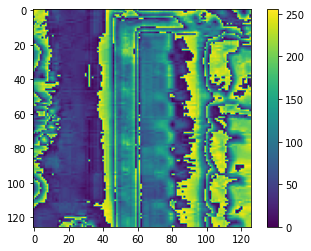

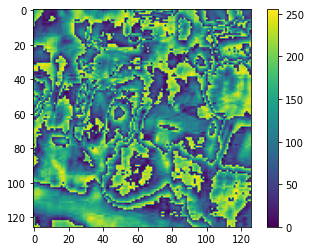

In [98]:
for i in np.arange(0, 3):
    plt.imshow((tercera_capa[i, :, :, 1] * 255).astype(np.uint8))
    plt.colorbar()
    plt.show()

# Red neuronal con learning rate

RED NEURONAL CONVOLUCIONAL

Epoch 1/15
157/157 [==============================] - 23s 144ms/step - loss: 0.5171 - accuracy: 0.7581 - val_loss: 0.4989 - val_accuracy: 0.7552
Epoch 2/15
157/157 [==============================] - 23s 145ms/step - loss: 0.2506 - accuracy: 0.9078 - val_loss: 0.2164 - val_accuracy: 0.9258
Epoch 3/15
157/157 [==============================] - 23s 145ms/step - loss: 0.1908 - accuracy: 0.9301 - val_loss: 0.1777 - val_accuracy: 0.9377
Epoch 4/15
157/157 [==============================] - 23s 143ms/step - loss: 0.1585 - accuracy: 0.9435 - val_loss: 0.1582 - val_accuracy: 0.9429
Epoch 5/15
157/157 [==============================] - 23s 144ms/step - loss: 0.1395 - accuracy: 0.9499 - val_loss: 0.1526 - val_accuracy: 0.9417
Epoch 6/15
157/157 [==============================] - 23s 145ms/step - loss: 0.1236 - accuracy: 0.9568 - val_loss: 0.1413 - val_accuracy: 0.9499
Epoch 7/15
157/157 [==============================] - 23s 144ms/step - loss: 0.1124 - accuracy: 0.9610

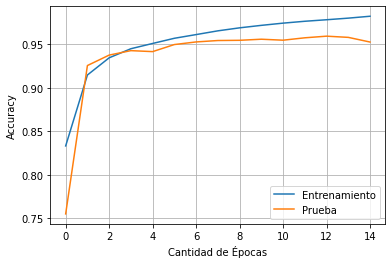

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
activation_8 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 61, 61, 64)        256 

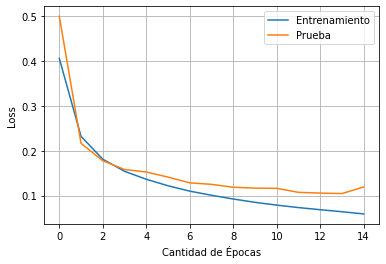

In [67]:
#RED NEURONAL CONVOLUCIONAL

import tensorflow
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import cv2
import random
import numpy as np

print('RED NEURONAL CONVOLUCIONAL')
print('')

#Estructura de la red neuronal
Imagen_de_entrada = layers.Input(shape = (128, 128, 3)) #Capa de entrada
X = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = None)(Imagen_de_entrada) #Capa de convolución
X = layers.BatchNormalization()(X) #Capa de normalización y relu
X = layers.Activation("relu")(X)
X = layers.MaxPooling2D(pool_size = (2, 2))(X) #Capa de pooling
X = layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = None)(X) #Segunda capa de convolución
X = layers.BatchNormalization()(X) #Capa de normalización y relu
X = layers.Activation("relu")(X)
X = layers.MaxPooling2D(pool_size = (2, 2))(X) #Capa de pooling

#Red fully connected
Flatten = layers.Flatten()(X) #Capa de flatten
X = layers.Dense(32, activation = "relu")(Flatten) #Capa oculta
X = layers.Dense(64, activation = "relu")(X) #Capa oculta
Salida = layers.Dense(units = 2, activation = 'softmax')(X) #Capa de salida

#Instancia de clase
Red_Neuronal = keras.Model(inputs = Imagen_de_entrada, outputs = Salida)

#Compilación de modelo
Red_Neuronal.compile(loss = 'binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(lr=0.00001), metrics = ['accuracy'])

#Entrenamos la red con nuestros datos
Historia = Red_Neuronal.fit(x = X_train, y = y_train, epochs = 15, batch_size = 256, validation_data = (X_val, y_val))

#Grafico las métricas de mi red

plt.plot(Historia.history['accuracy'], label = 'Entrenamiento')
plt.plot(Historia.history['val_accuracy'], label = 'Prueba')
plt.grid()
plt.xlabel('Cantidad de Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(Historia.history['loss'], label = 'Entrenamiento')
plt.plot(Historia.history['val_loss'], label = 'Prueba')
plt.grid()
plt.xlabel('Cantidad de Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Muestro arquitectura y parámetros de mi red
Red_Neuronal.summary()

In [68]:
Red_Neuronal.save('Modelo_learning_rate.h5') #Guardamos el modelo

# Evaluamos resultados con datos que nunca vio (test set)

In [71]:
val_loss, val_accuracy = Red_Neuronal.evaluate(x = X_val, y = y_val)

250/250 [==============================] - 2s 7ms/step - loss: 0.1193 - accuracy: 0.9528


In [72]:
test_loss, test_accuracy = Red_Neuronal.evaluate(x = X_test, y = y_test)

63/63 [==============================] - 1s 8ms/step - loss: 0.0912 - accuracy: 0.9655


### Con estos resultados podemos concluir que el modelo se ajusta bien a nuestros datos y predice las clases con un accuracy de 0.96 luego de haber realizado una aumentación de datos de entreamiento (40000), utilizado binary_crossentropy como función de pérdida y utilizado un pequeño learning rate en el optimizador Adam.